IMPORT IMPLEMENTATION

In [934]:
from bertopic import BERTopic
from bs4 import BeautifulSoup
from collections import Counter, deque
import csv
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import os
import pandas as pd
import random
import re 
import requests
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string
import time
import token 
from urllib.parse import urljoin, urlparse, unquote

In [935]:
nltk.download('punkt')
nltk.download('punkt_tab') # Nécessaire pour les nouvelles versions
nltk.download('wordnet')
nltk.download('omw-1.4')   # Souvent requis par le lemmatizer
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

IMPLEMENTATION OF CONSTANTS

In [936]:
# --- CONFIGURATION OF COLORS ---

GREEN = "\033[92m"
RED = "\033[91m"
YELLOW = "\033[93m"
BLUE = "\033[94m"
RESET = "\033[0m"

In [937]:
# --- CONFIGURATION OF HEADERS ---

HEADER_BROWSER = {
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/143.0.0.0 Safari/537.36 Edg/143.0.0.0",
    "Accept-Language": "en-US,en;q=0.5",
    "Referer": "https://www.google.com/"}

session = requests.Session()
session.headers.update(HEADER_BROWSER)

In [938]:
# --- CONFIGURATION OF FILTERS ---

Filters_MBG = [r'/products?/', r'/shop/', r'/search?', r'/store/', r'/cart', r'/checkout', r'/account', 
           r'/login', r'/register', r'/tag', r'/search', r'#', "youtube.com", 
           "instagram.com", "facebook.com", "twitter.com", "pinterest.com", "linkedin.com", "tiktok.com", 
           "amazon.com", "google.com"]

In [939]:
# --- CONFIGURATION OF SEED LINKS FOR WIKIPEDIA ---

wiki_seed_pages = [ # Our selection of a few pages = starting list
    "https://en.wikipedia.org/wiki/Lifestyle",
    "https://en.wikipedia.org/wiki/Quality_of_life",
    "https://en.wikipedia.org/wiki/Standard_of_living",
    "https://en.wikipedia.org/wiki/Healthy_lifestyle",
    "https://en.wikipedia.org/wiki/Physical_fitness",
    "https://en.wikipedia.org/wiki/Well-being",
    "https://en.wikipedia.org/wiki/Mental_health",
    "https://en.wikipedia.org/wiki/Healthy_diet",
    "https://en.wikipedia.org/wiki/Nutrition",
    "https://en.wikipedia.org/wiki/Work%E2%80%93life_balance", # Attention ?
    "https://en.wikipedia.org/wiki/Leisure",
    "https://en.wikipedia.org/wiki/Hobby",
    "https://en.wikipedia.org/wiki/Travel",
    "https://en.wikipedia.org/wiki/Outdoor_recreation",
    "https://en.wikipedia.org/wiki/Sustainable_living",
    "https://en.wikipedia.org/wiki/Sport",
    "https://en.wikipedia.org/wiki/Home",
    "https://en.wikipedia.org/wiki/Fashion",
    "https://en.wikipedia.org/wiki/Personal_care"]

IMPLEMENTATION OF DEFINITIONS

In [940]:
def get_filenames(source_name):
    directory_name = "data"
    if not os.path.exists(directory_name):
            os.makedirs(directory_name)
            print(f"{GREEN}Created directory : {directory_name}{RESET}")
    
    # Avertissement si écrasement (juste pour info)
    if os.path.exists(source_name):
        print(f"{BLUE}Note : The file is overwritten{RESET}") 
    
    base_name = source_name.replace(" ", "_")

    return {"raw":       os.path.join(directory_name, f"{base_name}_raw_html.csv"),
            "corpus":    os.path.join(directory_name, f"{base_name}_corpus.csv"),
            "cleaned":   os.path.join(directory_name, f"{base_name}_cleaned.csv"),
            "norm":      os.path.join(directory_name, f"{base_name}_corpus_norm.csv"),
            "tokenized": os.path.join(directory_name, f"{base_name}_corpus_tokenized.csv")}

In [941]:
def fetch_url(url) :

    try:
        response = session.get(url, timeout=10)
        if response.status_code == 200: 
            return response # If the status code is not OK (200) the function return none and an error message
        else:
            print(f"Failed to fetch the url: {url} with status code {response.status_code}")
            return None
    
    except requests.RequestException:
        return None

In [942]:
def to_soup(url):
    response = fetch_url(url)
    if response:  # If the response is not none, the function return the beautiful soup object
        return BeautifulSoup(response.text, 'html.parser') 
    else:
        return None

In [943]:
def extract_MBG_links(url_MBG, max_levels=3):
    queue = deque([(url_MBG, 0)])
    links_MBG = set([url_MBG])
    start_domain = urlparse(url_MBG).netloc

    while queue:
        current_url, current_level = queue.popleft()

        # Si on atteint le niveau max, on arrête de creuser à partir d'ici
        if current_level >= max_levels:
            continue
    
        soup = to_soup(current_url)
        if not soup:
            continue

        content_area = soup.body # Stay large (here) to get more links
        if not content_area:
            continue

        for item in content_area.find_all('a', href=True):
            href = item.get('href')
            if href.startswith('mailto:') or href.startswith('tel:') or href.startswith('javascript:'):
                continue
            full_url = urljoin(current_url, href)
                    
            # Si nouveau lien trouvé
            if any(filter in full_url for filter in Filters_MBG):
                continue
            
            if full_url not in links_MBG:
                links_MBG.add(full_url)

                # On ajoute à la queue SEULEMENT si c'est interne (pour continuer le crawl)
                if urlparse(full_url).netloc == start_domain:
                    queue.append((full_url, current_level + 1))
                    
    return links_MBG

In [944]:
def extract_wikipedia_links(url):
    soup = to_soup(url)

    if not soup:
        return set()

    links_wiki = set()

    # --- Main content ---
    to_visit = soup.find_all('div', class_="mw-content-ltr mw-parser-output")

    for div in to_visit:
        for item in div.find_all('a', href=True):
            href = item.get('href')
            if href.startswith("/wiki/") and ":" not in href:
                links_wiki.add(urljoin(url, href))

    return links_wiki

In [945]:
def crawl_wiki_seed_links(wiki_seed_pages):
    wiki_all_pages = set(wiki_seed_pages) # Set() avoids duplication, unlike lists
    dico_wiki_links = {}

    for url in wiki_seed_pages:
        crawl_links = extract_wikipedia_links(url)
        dico_wiki_links[url] = crawl_links
        wiki_all_pages.update(crawl_links) # Only add new links

    return list(wiki_all_pages)

In [946]:
def wiki_url_to_label(url):
    title = urlparse(url).path.split("/")[-1]
    title = unquote(title)
    title = title.replace("_", " ")
    # ajout d'un suffixe si la page contient parenthèses
    if "(" in title:
        title = title.replace("(", " (").replace(")", ")")
    return title

In [947]:
def get_html_content(links, max=None):
    content = []
    failed_links = []

    for link in links[:max]:
        response = fetch_url(link)
        if response:
            content.append({'url': link, 'html': response.text})
        else:
            failed_links.append(link)

    print(f"{GREEN}Fetched: {len(content)}{RESET}")
    print(f"{RED}Failed: {len(failed_links)}{RESET}")

    return content, failed_links 

In [948]:
def clean_html(html):

    if html is None or pd.isna(html) or not isinstance(html, str):
        return ""
    
    soup = BeautifulSoup(html, 'html.parser')

    for tag in soup(['script', 'style', 'noscript']):  # Supress any unessecary tags
        tag.decompose()
    
    text = soup.get_text(separator=' ', strip=True)  # Collect all visible text
    text = re.sub(r'\s+', ' ', text)  # Supress any unecessary spaces

    return text

In [949]:
def clean_csv_file(input_csv, output_csv):
    df = pd.read_csv(input_csv)  # Take the csv file with the raw html as the input

    if 'corpus_text' not in df.columns:  # Verify that the html colon exists
        raise ValueError(f"The corpus column is missing in: {input_csv}")

    df['corpus_text'] = df['corpus_text'].fillna("")   
    df['cleaned_text'] = df['corpus_text'].apply(clean_html)  # Cleans the html column
    df = df[['url', 'cleaned_text']]  # Keep the url and text colon (not the raw html)

    df.to_csv(output_csv, index=False, encoding='utf-8')  # Creats a new csv file as the output of the function

    return df

In [950]:
def save_to_csv(data, filename):
    
    if not data:
        print(f"{RED}No data to save.{RESET}")
        return

    if not os.path.exists(filename):
        print(f"{RED} ERROR : File {filename} was not created")
 
    # Get the keys from the first dictionary for the CSV header from get_html_content
    fieldnames = data[0].keys() # Detection of the existing colons in the data file
    
    try:
        with open(filename, 'w', newline='', encoding='utf-8') as f: # Opens the csv file as utf-8
            writer = csv.DictWriter(f, fieldnames=fieldnames, quoting=csv.QUOTE_ALL) # Initialising a writer to write the dictionary into the csv file
            writer.writeheader() # writes the colons headers
            writer.writerows(data) # writes the rows
        print(f"{GREEN}Success! Data saved to: {RESET}{os.path.abspath(filename)}")
        
    except Exception as e:
        print(f"{RED}Error saving file: {e}{RESET}")

In [951]:
def get_corpus(html):
    if not html: 
        return ""

    try:
        soup = BeautifulSoup(html, "lxml") #pip install lmxl requis
    except:
        soup = BeautifulSoup(html, "html.parser")

    unwanted_tags = ["script", "style", "nav", "noscript", "header", "footer", "aside", "form", "input", "button", "meta", "svg"]

    for tag in soup(unwanted_tags):
        tag.decompose()
    
    is_wikipedia = soup.find_all('div', class_="mw-content-ltr mw-parser-output")

    if not is_wikipedia:
        regex_string = r"cookie-banner|popup|ad(vertisement)?|social|share|banner|newsletter|widget"
        unwanted_patterns = re.compile(regex_string, re.IGNORECASE)

        tags_to_remove = soup.find_all(attrs={"class": unwanted_patterns}) + soup.find_all(attrs={"id": unwanted_patterns})     

        for tag in tags_to_remove:
            tag.decompose()
        
    raw_text = soup.get_text(separator=' ', strip=True)
    text = ' '.join(raw_text.split())

    return text

In [952]:
def normalize_html(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()  # convert all letters to lowercase
    text = re.sub(r'\[\d+\]', ' ', text)  # remove reference numbers like [1], [2], etc.
    text = re.sub(r'\d+', ' ', text)  # remove all numbers
    text = re.sub(r'[^a-z\s]', ' ', text)  # keep only English letters and spaces
    text = re.sub(r'\s+', ' ', text)  # replace multiple spaces with a single space
    return text.strip()  # remove leading and trailing spaces

In [953]:
def normalize_csv_file(input_csv, output_csv):
    df = pd.read_csv(input_csv)  # Take the csv file with the cleaned text as the input

    if 'cleaned_text' not in df.columns:  # Verify that the cleaned text colon exists
        raise ValueError(f"The cleaned text is missing in: {input_csv}")

    df['cleaned_text'] = df['cleaned_text'].fillna("") # On force tout en string vide si c'est NaN
    df['normalized_text'] = df['cleaned_text'].apply(normalize_html)  # normalize the cleaned text
    df = df[['url', 'normalized_text']]  # keep the url and normalized text 

    df.to_csv(output_csv, index=False, encoding='utf-8')  # creats a new csv file as the output of the function

    return df

In [954]:
nltk.download('stopwords') 
stop_words = list(set(stopwords.words('english'))) + ["'s"]

stop_words = set(stopwords.words('english'))

#stem = nltk.stem.SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

def tokenize_html(text):
    if not isinstance(text, str) or pd.isna(text):
        return [] # Return empty list for non-string or NaN inputs (= when text is missing)
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in string.punctuation]  # remove punctuation
    tokens = [token for token in tokens if token not in stop_words]  # remove stopwords
    #tokens = [stem.stem(token) for token in tokens]  # apply stemming (racinisation)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # apply lemmatization
    tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens]
    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [955]:
def tokenize_csv_file(input_csv, output_csv):
    df = pd.read_csv(input_csv)  # Take the csv file with the normalized text as the input

    if 'normalized_text' not in df.columns:  # Verify that the normalized text colon exists
        raise ValueError(f"The normalized text is missing in: {input_csv}")

    df['normalized_text'] = df['normalized_text'].fillna("") # Replace holes by nothing to avoid error due to 'NaN'

    df['tokenized_text'] = df['normalized_text'].apply(tokenize_html)  # cleans the html colon
    df = df[['url', 'tokenized_text']]  # keep the url and text colon (not the raw html)

    df.to_csv(output_csv, index=False, encoding='utf-8')  # creats a new csv file as the output of the function

    return df

CONFIGURATION

In [956]:
sources = [
    {"name": "MBG",
     "start_url": "https://www.mindbodygreen.com/",
     "crawler_func": extract_MBG_links,
     "output_file": "data/MBG.csv"},  # We pass the specific function without calling it ()
    {"name": "wiki",
     "start_url": wiki_seed_pages,
     "crawler_func": crawl_wiki_seed_links,
     "output_file": "data/wiki.csv"}]

EXECUTION

In [957]:
"""========================== SOURCES PIPELINE =========================="""

"""=== SETUP ==="""
for source in sources:
    filename = source["output_file"]
    source_name = source["name"]
    start_point = source["start_url"]

    files = get_filenames(source_name)

    print(f"=== SOURCE TRAITEMENT : {source_name} ===")

    print("\n=== CRAWLING ===")
    print(f"{BLUE}[{source_name}] Starting the crawling...{RESET}")    
    crawled_links = source["crawler_func"](start_point)
    print(f"-> Found {len(crawled_links)} links")

    print("\n=== SCRAPING ===")
    # 1. Scrap the data
    print(f"{BLUE}[{source_name}] Starting the scraping...{RESET}")

    # 2. Extract the data
    content, failed_links = get_html_content(list(crawled_links), max=10)

    # 3. Conversion to DataFrame (This is a memory object)
    df = pd.DataFrame(content)

    # 4. Save the raw data (only backup)
    df.to_csv(files["raw"], index=False, quoting=csv.QUOTE_NONNUMERIC)

    df['corpus_text'] = df['html'].apply(get_corpus)

    df[['url', 'corpus_text']].to_csv(files["corpus"], index=False)

    # 5. Save the data to the file
    #save_to_csv(content, filename)
    print(f"-> {len(content)} pages téléchargées avec succès.")
    print(f"-> {len(failed_links)} échecs.")
    print(f"{GREEN}Raw HTML data saved to {files['raw']}{RESET}")

    print("\n=== CORPUS EXTRACTION ===")
    print(f"{BLUE}[{source_name}] Extracting the corpus...{RESET}")
    #corpus_csv_file(files["raw"], files["corpus"])
    print(f"{GREEN}Corpus data saved to {files['raw']}{RESET}")

    print("\n=== CLEANING ===")
    print(f"{BLUE}{source_name} Cleaning the data...{RESET}")
    clean_csv_file(files["corpus"], files["cleaned"])
    print(f"{GREEN}Cleaned text saved to {files['raw']}{RESET}")

    print("\n=== NORMALIZATION ===")
    print(f"{BLUE}{source_name} Normalizing the data...{RESET}")
    normalize_csv_file(files["cleaned"], files["norm"])
    print(f"{GREEN}Normalized text saved to {files['raw']}{RESET}")

    print("\n=== TOKENIZATION ===")
    print(f"{BLUE}{source_name} Tokenizing text...{RESET}")
    df_final = tokenize_csv_file(files["norm"], files["tokenized"])

    print("\n=== LOAD DATA ===")
    #filename = source.get("output_file", f"{source_name}_data.csv")
    #df.to_csv(filename, index=False)
    print(f"{GREEN}Succès ! Final data in {files['tokenized']}{RESET}\n")
    print(df_final.head()) # Display the 5 first lines of the final dataframe

Created directory : data
=== SOURCE TRAITEMENT : MBG ===

=== CRAWLING ===
[MBG] Starting the crawling...
-> Found 7943 links

=== SCRAPING ===
[MBG] Starting the scraping...
Fetched: 10
Failed: 0
-> 10 pages téléchargées avec succès.
-> 0 échecs.
Raw HTML data saved to data\MBG_raw_html.csv

=== CORPUS EXTRACTION ===
[MBG] Extracting the corpus...
Corpus data saved to data\MBG_raw_html.csv

=== CLEANING ===
MBG Cleaning the data...
Cleaned text saved to data\MBG_raw_html.csv

=== NORMALIZATION ===
MBG Normalizing the data...
Normalized text saved to data\MBG_raw_html.csv

=== TOKENIZATION ===
MBG Tokenizing text...

=== LOAD DATA ===
Succès ! Final data in data\MBG_corpus_tokenized.csv

                                                 url  \
0  https://www.mindbodygreen.com/partner/haven-we...   
1  https://www.mindbodygreen.com/articles/how-tea...   
2  https://www.mindbodygreen.com/articles/2-place...   
3  https://www.mindbodygreen.com/articles/solawav...   
4  https://www.mindbody

In [958]:
# ... après la boucle ...
print(f"\n{BLUE}=== MERGING DATASETS ==={RESET}")
all_dfs = []
for source in sources:
    f_token = get_filenames(source["name"])["tokenized"]
    df = pd.read_csv(f_token)
    df['source_origin'] = source["name"] # On garde une trace de l'origine !
    all_dfs.append(df)

df_global = pd.concat(all_dfs, ignore_index=True)
df_global.to_csv("GLOBAL_dataset_tokenized.csv", index=False)


=== MERGING DATASETS ===


In [959]:
def build_term_document_matrix(documents, min_doc_freq=2, max_doc_freq=None):
    # Step 1: Build a vocabulary (unique terms across all documents)
    vocabulary = set(token for tokens in documents.values() for token in tokens)

    # Step 2: Count term frequencies for each document
    term_frequencies = {doc: Counter(tokens) for doc, tokens in documents.items()}

    # Step 3: Construct the term-document matrix
    td_matrix = pd.DataFrame(
        {term: [term_frequencies[doc].get(term, 0) for doc in documents] for term in vocabulary},
        index = documents.keys()
    )

    # Step 4: Filter terms that appear in fewer / more than x documents
    document_frequency = (td_matrix > 0).sum(axis=0)

    if min_doc_freq is not None:
        td_matrix = td_matrix.loc[:, document_frequency >= min_doc_freq]

    if max_doc_freq is not None:
        document_frequency = (td_matrix > 0).sum(axis=0)
        td_matrix = td_matrix.loc[:, document_frequency <= max_doc_freq]

    vocabulary = td_matrix.columns.tolist()

    return td_matrix, vocabulary

In [960]:
tokenized_dict = dict(zip(df_final["url"], df_final["tokenized_text"]))

In [961]:
MBG_td_matrix, MBG_vocab = build_term_document_matrix(tokenized_dict, min_doc_freq=10, max_doc_freq=60)

print(MBG_vocab[:20])
print(MBG_td_matrix)

['org', 'wikipedia', 'jump', 'http', 'short', 'title', 'encyclopedia', 'php', 'content', 'index', 'oldid', 'article', 'free', 'description', 'en', 'hide', 'wikidata', 'add', 'w', 'topic']
                                                    org  wikipedia  jump  \
https://en.wikipedia.org/wiki/Bodhipakkhiy%C4%8...    1          3     1   
https://en.wikipedia.org/wiki/Richard_Riordan         1          4     1   
https://en.wikipedia.org/wiki/Mentorship              5          4     2   
https://en.wikipedia.org/wiki/35-hour_workweek        1          3     1   
https://en.wikipedia.org/wiki/International_air...    1          4     1   
https://en.wikipedia.org/wiki/Health_impact_ass...    1          3     1   
https://en.wikipedia.org/wiki/Timatic                 1          3     1   
https://en.wikipedia.org/wiki/Sophist                 1          3     1   
https://en.wikipedia.org/wiki/Group_emotion           1          4     1   
https://en.wikipedia.org/wiki/Hemp                  

In [962]:
row_sums = MBG_td_matrix.sum(axis=1)  # Total tokens per document (row)
tf = MBG_td_matrix.div(row_sums, axis=0)
df = (MBG_td_matrix > 0).sum(axis=0)  # Number of documents containing each term (column)
N = MBG_td_matrix.shape[0]  # Number of documents
idf = np.log((N) / (df))
tf_idf = tf.mul(idf, axis=1)
print(tf_idf)

                                                    org  wikipedia  jump  \
https://en.wikipedia.org/wiki/Bodhipakkhiy%C4%8...  0.0        0.0   0.0   
https://en.wikipedia.org/wiki/Richard_Riordan       0.0        0.0   0.0   
https://en.wikipedia.org/wiki/Mentorship            0.0        0.0   0.0   
https://en.wikipedia.org/wiki/35-hour_workweek      0.0        0.0   0.0   
https://en.wikipedia.org/wiki/International_air...  0.0        0.0   0.0   
https://en.wikipedia.org/wiki/Health_impact_ass...  0.0        0.0   0.0   
https://en.wikipedia.org/wiki/Timatic               0.0        0.0   0.0   
https://en.wikipedia.org/wiki/Sophist               0.0        0.0   0.0   
https://en.wikipedia.org/wiki/Group_emotion         0.0        0.0   0.0   
https://en.wikipedia.org/wiki/Hemp                  0.0        0.0   0.0   

                                                    http  short  title  \
https://en.wikipedia.org/wiki/Bodhipakkhiy%C4%8...   0.0    0.0    0.0   
https://en.wiki

,https://en.wikipedia.org/wiki/Bodhipakkhiy%C4%81dhamm%C4%81,https://en.wikipedia.org/wiki/Richard_Riordan,https://en.wikipedia.org/wiki/Mentorship,https://en.wikipedia.org/wiki/35-hour_workweek,https://en.wikipedia.org/wiki/International_airport,https://en.wikipedia.org/wiki/Health_impact_assessment,https://en.wikipedia.org/wiki/Timatic,https://en.wikipedia.org/wiki/Sophist,https://en.wikipedia.org/wiki/Group_emotion,https://en.wikipedia.org/wiki/Hemp
https://en.wikipedia.org/wiki/Bodhipakkhiy%C4%81dhamm%C4%81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://en.wikipedia.org/wiki/Richard_Riordan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://en.wikipedia.org/wiki/Mentorship,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://en.wikipedia.org/wiki/35-hour_workweek,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://en.wikipedia.org/wiki/International_airport,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://en.wikipedia.org/wiki/Health_impact_assessment,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://en.wikipedia.org/wiki/Timatic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://en.wikipedia.org/wiki/Sophist,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://en.wikipedia.org/wiki/Group_emotion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://en.wikipedia.org/wiki/Hemp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


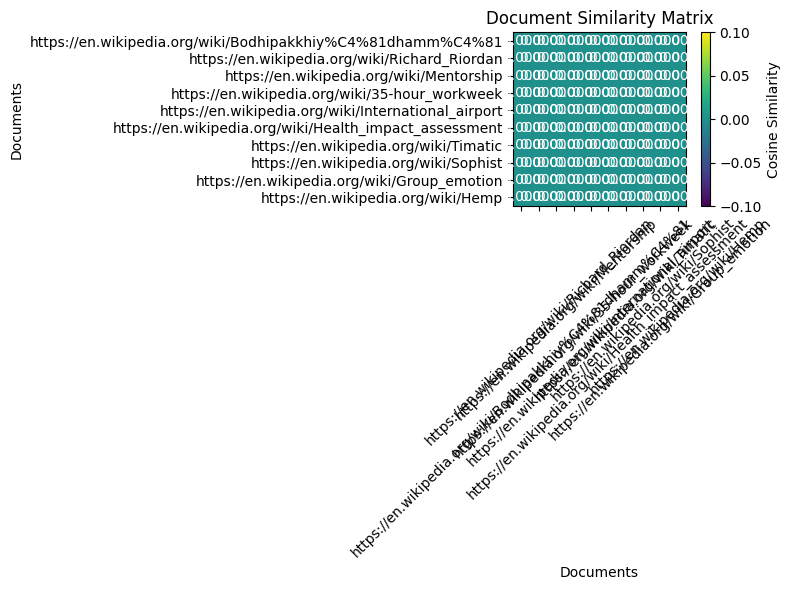

In [963]:
# Compute the cosine similarity matrix
similarity_matrix_tfidf = cosine_similarity(tf_idf)

# Convert to a DataFrame for better readability (optional)
similarity_df_tfidf = pd.DataFrame(similarity_matrix_tfidf, index=tf_idf.index, columns=tf_idf.index)

# Display the similarity DataFrame
display(similarity_df_tfidf)

def plot_similarity_matrix(similarity_df):
    # Plot the similarity matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(similarity_df, interpolation='nearest', cmap='viridis')
    plt.colorbar(label='Cosine Similarity')
    plt.title('Document Similarity Matrix')
    plt.xticks(ticks=range(len(similarity_df.columns)), labels=similarity_df.columns, rotation=45)
    plt.yticks(ticks=range(len(similarity_df.index)), labels=similarity_df.index)
    plt.xlabel('Documents')
    plt.ylabel('Documents')

    # Optionally, annotate the cells with similarity values
    for i in range(len(similarity_df)):
        for j in range(len(similarity_df)):
            plt.text(j, i, f"{similarity_df.iloc[i, j]:.3f}", ha='center', va='center', color='white')

    plt.tight_layout()

plot_similarity_matrix(similarity_df_tfidf)

In [964]:

# Load corpus
files_wiki = get_filenames("wiki")
df = pd.read_csv(files_wiki["norm"]) 

documents = df["normalized_text"].astype(str).tolist()
documents = [d for d in documents if len(d.split()) > 100]  # remove documents with less than a 100 words (they are too short and only makes noise)

# Embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")  # It transforms every document in a vector which have meaning 

# Vectorizer
vectorizer_model = CountVectorizer(
    stop_words="english",
    min_df=3,
    ngram_range=(1, 2)
)

# KMeans clustering (NO hdbscan)  -> clustering of documents per topic (we can ask for x cluster)
cluster_model = KMeans(
    n_clusters=6,
    random_state=42,
    n_init="auto"
)

# BERTopic without hdbscan
topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    hdbscan_model=cluster_model,
    verbose=True
)

topics, probs = topic_model.fit_transform(documents)

print(topic_model.get_topic_info())

2025-12-31 16:57:04,211 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
2025-12-31 16:57:05,189 - BERTopic - Embedding - Completed ✓
2025-12-31 16:57:05,190 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-31 16:57:05,221 - BERTopic - Dimensionality - Completed ✓
2025-12-31 16:57:05,222 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-31 16:57:05,228 - BERTopic - Cluster - Completed ✓
2025-12-31 16:57:05,232 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-31 16:57:05,281 - BERTopic - Representation - Completed ✓


   Topic  Count                                            Name  \
0      0      3  0_articles_articles containing_text_containing   
1      1      2               1_american_century_april_articles   
2      2      2    2_international_convention_retrieved_october   
3      3      1                 3_right_seven_articles_december   
4      4      1                   4_france_articles_law_january   
5      5      1                   5_work_new_retrieved_teachers   

                                      Representation  \
0  [articles, articles containing, text, containi...   
1  [american, century, april, articles, wikipedia...   
2  [international, convention, retrieved, october...   
3  [right, seven, articles, december, language te...   
4  [france, articles, law, january, articles unso...   
5  [work, new, retrieved, teachers, business, kno...   

                                 Representative_Docs  
0  [health impact assessment wikipedia jump to co...  
1  [sophist wikipedia jump 

In [965]:
def filter_links(links, required_keywords=None, domain=None, already_seen=None):
    if required_keywords is None:  # If no list of required keywords is given then we create an empty one
        required_keywords = []
    if already_seen is None:  # If no list of already seen links is given then we create an empty one
        already_seen = set()
    
    filtered = []
    for l in links:
        l_lower = l.lower()  # Transformation of capital letter into lower case letter
        if required_keywords and not any(keyword.lower() in l_lower for keyword in required_keywords):  # The function skip the url if no required keywords are in the url
            continue
        if domain and urlparse(l).netloc != domain:  # The function filter the links that are not in the domain
            continue
        if l in already_seen:  # The function filter the links already in the list of links
            continue
        filtered.append(l) # If the url past all the filter, it is added to the list of links
    return filtered

In [966]:
def create_nodes_csv(all_links, output_file="nodes.csv", label_function=None):
    nodes = set(all_links.keys())
    for targets in all_links.values():
        nodes.update(targets)

    with open(output_file, mode="w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)

        # En-tête dynamique
        if label_function:
            writer.writerow(["id", "label"])
        else:
            writer.writerow(["node_id"])
        print("label_function:", label_function)
        for node in nodes:
            if label_function:
                try:
                    label = label_function(node)
                except Exception:
                    label = node  # sécurité
                writer.writerow([node, label])
            else:
                writer.writerow([node])

    print(f"Nodes CSV created: {len(nodes)} nodes")

In [967]:
def create_edges_csv(links, output_file="edges.csv"):
    """
    Crée un fichier CSV des edges (liens entre pages)
    """
    with open(output_file, mode="w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["source", "target"])

        edge_count = 0
        for source, targets in links.items():
            for target in targets:
                writer.writerow([source, target])
                edge_count += 1

    print(f"Edges CSV created: {edge_count} edges")

In [968]:
create_nodes_csv(dico_wiki_links, "wikipedia_nodes.csv", label_function = wiki_url_to_label)

create_edges_csv(dico_wiki_links, "wikipedia_edges.csv")

NameError: name 'dico_wiki_links' is not defined